In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from tqdm import tqdm
from preprocessing import PastUserState,extract_data_mooc,PreviousItemInteraction, extractFeatures,extractItemUserId,extractNextStateItem,extractNextUserState,UserNextInteraction, delta, t_batch_update,train_test_split,train_test_stratified_split
from model import RODIE
from sklearn.manifold import TSNE
from train import dynamic_embedding,train_rodie
from  torch import nn
from torch.nn import RNNCell
from torch.nn.functional import one_hot
import math
from torch.nn import functional as F
from torch.nn import MSELoss, HuberLoss,L1Loss,CrossEntropyLoss
from tqdm import tqdm


torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [2]:
## Téléchargement des données
!wget https://snap.stanford.edu/data/act-mooc.tar.gz
!tar -xzf  act-mooc.tar.gz
!mkdir data

--2022-03-21 12:38:02--  https://snap.stanford.edu/data/act-mooc.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5378133 (5.1M) [application/x-gzip]
Saving to: ‘act-mooc.tar.gz’

act-mooc.tar.gz     100%[===================>]   5.13M  4.68MB/s    in 1.1s    

2022-03-21 12:38:03 (4.68 MB/s) - ‘act-mooc.tar.gz’ saved [5378133/5378133]



In [3]:
features = pd.read_csv("act-mooc/mooc_action_features.tsv",sep="\t")
labels = pd.read_csv("act-mooc/mooc_action_labels.tsv",sep="\t")
users = pd.read_csv("act-mooc/mooc_actions.tsv",sep="\t")

#### Load & Preprocess Data

In [4]:
mooc_data = extract_data_mooc()


In [5]:
delta_u  = delta(mooc_data.copy(),"user_id")
delta_i  = delta(mooc_data.copy(),"item_id")
PreviousItemInteraction_ = PreviousItemInteraction(mooc_data.copy()).astype(int)
next_state_user = PastUserState(mooc_data.copy()).astype(int)

delta user_id
delta item_id


In [6]:
interaction_column_name = "PreviousItemInteraction"

In [7]:
mooc_data['delta_u'] = delta_u/np.std(delta_u)
mooc_data['delta_i'] = delta_i/np.std(delta_i)
mooc_data[interaction_column_name] = PreviousItemInteraction_
mooc_data['previous_state_label'] = next_state_user
list_moins_un = list(mooc_data[mooc_data['previous_state_label'] == -1].index.values)
mooc_data.loc[list_moins_un,'previous_state_label'] = 0
data = mooc_data.copy()
#data = data[data.next_state_user != -1]

data = data[['user_id', 'item_id', 'timestamp', 'state_label','delta_u', 'delta_i', interaction_column_name, 'previous_state_label','f1', 'f2', 'f3','f4']]
data.head()

,user_id,item_id,timestamp,state_label,delta_u,delta_i,PreviousItemInteraction,previous_state_label,f1,f2,f3,f4
ACTIONID,,,,,,,,,,,,
0,0,0,0.0,0,0.000000,0.000000,-1,0,-0.319991,-0.435701,0.106784,-0.067309
1,0,1,6.0,0,0.000064,0.000000,0,0,-0.319991,-0.435701,0.106784,-0.067309
2,0,2,41.0,0,0.000372,0.000000,1,0,-0.319991,-0.435701,0.106784,-0.067309
3,0,1,49.0,0,0.000085,0.007652,2,0,-0.319991,-0.435701,0.106784,-0.067309
4,0,2,51.0,0,0.000021,0.001780,1,0,-0.319991,-0.435701,0.106784,-0.067309


### T-batches

#### Train / Test SPLIT

In [8]:
t_batches_train = t_batch_update(data.sort_values(['timestamp']))


T-Batch start...
Number of interaction = 411749
T-Batch ends !


In [9]:
len(t_batches_train)

63461

##### Initialize Device

In [10]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
print('Using device:', device)

Using device: cuda


##### Initialize the model

In [11]:
# Its important to add this to the loss, because the dataset is unbalanced
weight_ratio = torch.Tensor([1.0,100.0]).to(device)
print(weight_ratio)

tensor([  1., 100.], device='cuda:0')


##### Train Loop

In [12]:
# Test le modèle sur peu de données
import itertools
t_batches_ = dict(itertools.islice(t_batches_train.items(), 5000))

In [13]:
embedding_dim = 32
data_torch2 = torch.from_numpy(data.values.astype(np.float32))
#U_dynamic,I_dynamic = dynamic_embedding(data_torch2,embedding_dim)  # Initial dynamic embedding
    
#U_dynamic = U_dynamic.to(device)
#I_dynamic = I_dynamic.to(device)

model = RODIE(embedding_dim,data_torch2,device=device,activation_rnn="tanh").to(device)

Number of users of 7047 
 Number of items 97 

Dataset size [411749, 12]
Initialisation of static embedding... Done !
Static Embedding shape : Users [7047, 7047], 	 Items [98, 98]
Initialisation of rnn's with tanh activation function... Done !
Initialisation of MLP... Done !


In [14]:
# Test le modèle sur peu de données
import itertools
t_batches_ = dict(itertools.islice(t_batches_train.items(), 11000))

In [16]:
l = 0
for x,y in t_batches_.items():
  l +=(len(y))
l

54911

In [ ]:
n_epochs = 10
lambda_u = 1
lambda_i = 1
learning_rate=1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

model_,U,I = train_rodie(t_batches_,
          data_torch2,
          weight_ratio,
          model,
          optimizer,
          learning_rate,
          n_epochs,
          lambda_u,
          lambda_i,
          device
          )

ok
Initialisation of dynamic embedding... Done !
Dynamic Embedding shape : Users [7047, 32], 	 Items [98, 32]
Training...


 67%|██████▋   | 7332/11000 [00:57<00:28, 130.82it/s]

## TSNE

In [ ]:
from sklearn.decomposition import KernelPCA,PCA
tsne = TSNE(2,learning_rate='auto')
data_tsne = tsne.fit_transform(data_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [ ]:
l = []
for x,y in t_batches_train.items():
  l.append(y)


dd = sum(l, [])
ff = df_train.iloc[dd,:].copy()
list_of_change = ff[ff['next_state_user'] == 1]['user_id'].values


data_  = (U.detach().cpu().clone()).numpy()



In [ ]:
ff = pd.DataFrame(data_tsne,columns=["t1","t2"])
ff['labels'] = df['label']

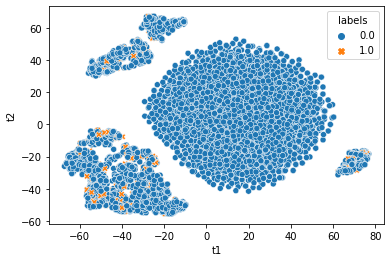

In [ ]:
import seaborn as sns
sns.scatterplot(data=ff, x="t1", y="t2", hue="labels",style="labels")
